In [ ]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k13_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_e_k5_b25_k13_b25_k21_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 276)
(878801, 3)
validation
(151459, 276)
(151459, 3)
test
(112754, 276)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 2048)              567296    


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 3354883 (12.80 MB)


Trainable params: 3354883 (12.80 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:19 - loss: 1.2276 - STD: 0.1064 - MAE: 0.4594

2/9 [=====>........................] - ETA: 1s - loss: 1.1509 - STD: 0.0954 - MAE: 0.4458  

3/9 [=========>....................] - ETA: 1s - loss: 1.1449 - STD: 0.1218 - MAE: 0.4374

4/9 [============>.................] - ETA: 1s - loss: 1.1418 - STD: 0.1331 - MAE: 0.4331

5/9 [===============>..............] - ETA: 1s - loss: 1.1369 - STD: 0.1356 - MAE: 0.4313

6/9 [===================>..........] - ETA: 0s - loss: 1.1296 - STD: 0.1331 - MAE: 0.4307

7/9 [======================>.......] - ETA: 2s - loss: 1.1233 - STD: 0.1264 - MAE: 0.4308

8/9 [=========================>....] - ETA: 1s - loss: 1.1171 - STD: 0.1171 - MAE: 0.4316

9/9 [==============================] - ETA: 0s - loss: 1.1138 - STD: 0.1079 - MAE: 0.4326

9/9 [==============================] - 22s 2s/step - loss: 1.1138 - STD: 0.1079 - MAE: 0.4326 - val_loss: 1.0955 - val_STD: 0.0298 - val_MAE: 0.4427


Epoch 2/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0945 - STD: 0.0299 - MAE: 0.4425

2/9 [=====>........................] - ETA: 1s - loss: 1.0930 - STD: 0.0270 - MAE: 0.4424

3/9 [=========>....................] - ETA: 1s - loss: 1.0901 - STD: 0.0269 - MAE: 0.4418

4/9 [============>.................] - ETA: 1s - loss: 1.0868 - STD: 0.0312 - MAE: 0.4408

5/9 [===============>..............] - ETA: 1s - loss: 1.0843 - STD: 0.0379 - MAE: 0.4396

6/9 [===================>..........] - ETA: 0s - loss: 1.0826 - STD: 0.0453 - MAE: 0.4384

7/9 [======================>.......] - ETA: 0s - loss: 1.0818 - STD: 0.0525 - MAE: 0.4373

8/9 [=========================>....] - ETA: 0s - loss: 1.0815 - STD: 0.0592 - MAE: 0.4362

9/9 [==============================] - ETA: 0s - loss: 1.0814 - STD: 0.0650 - MAE: 0.4353

9/9 [==============================] - 3s 327ms/step - loss: 1.0814 - STD: 0.0650 - MAE: 0.4353 - val_loss: 1.0785 - val_STD: 0.1102 - val_MAE: 0.4278


Epoch 3/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0791 - STD: 0.1104 - MAE: 0.4278

2/9 [=====>........................] - ETA: 1s - loss: 1.0772 - STD: 0.1068 - MAE: 0.4281

3/9 [=========>....................] - ETA: 1s - loss: 1.0758 - STD: 0.1020 - MAE: 0.4288

4/9 [============>.................] - ETA: 1s - loss: 1.0744 - STD: 0.0965 - MAE: 0.4295

5/9 [===============>..............] - ETA: 1s - loss: 1.0728 - STD: 0.0908 - MAE: 0.4302

6/9 [===================>..........] - ETA: 0s - loss: 1.0716 - STD: 0.0853 - MAE: 0.4308

7/9 [======================>.......] - ETA: 0s - loss: 1.0707 - STD: 0.0803 - MAE: 0.4313

8/9 [=========================>....] - ETA: 0s - loss: 1.0697 - STD: 0.0763 - MAE: 0.4316

9/9 [==============================] - ETA: 0s - loss: 1.0684 - STD: 0.0735 - MAE: 0.4317

9/9 [==============================] - 3s 332ms/step - loss: 1.0684 - STD: 0.0735 - MAE: 0.4317 - val_loss: 1.0505 - val_STD: 0.0543 - val_MAE: 0.4304


Epoch 4/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0522 - STD: 0.0555 - MAE: 0.4306

2/9 [=====>........................] - ETA: 1s - loss: 1.0473 - STD: 0.0583 - MAE: 0.4290

3/9 [=========>....................] - ETA: 1s - loss: 1.0420 - STD: 0.0617 - MAE: 0.4272

4/9 [============>.................] - ETA: 1s - loss: 1.0354 - STD: 0.0658 - MAE: 0.4249

5/9 [===============>..............] - ETA: 1s - loss: 1.0279 - STD: 0.0704 - MAE: 0.4222

6/9 [===================>..........] - ETA: 0s - loss: 1.0192 - STD: 0.0754 - MAE: 0.4190

7/9 [======================>.......] - ETA: 0s - loss: 1.0088 - STD: 0.0807 - MAE: 0.4153

8/9 [=========================>....] - ETA: 0s - loss: 0.9966 - STD: 0.0864 - MAE: 0.4110

9/9 [==============================] - ETA: 0s - loss: 0.9858 - STD: 0.0928 - MAE: 0.4062

9/9 [==============================] - 3s 327ms/step - loss: 0.9858 - STD: 0.0928 - MAE: 0.4062 - val_loss: 0.8297 - val_STD: 0.1629 - val_MAE: 0.3518


Epoch 5/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.8349 - STD: 0.1662 - MAE: 0.3517

2/9 [=====>........................] - ETA: 1s - loss: 0.8128 - STD: 0.1780 - MAE: 0.3436

3/9 [=========>....................] - ETA: 1s - loss: 0.7923 - STD: 0.1899 - MAE: 0.3353

4/9 [============>.................] - ETA: 1s - loss: 0.7743 - STD: 0.2014 - MAE: 0.3274

5/9 [===============>..............] - ETA: 1s - loss: 0.7572 - STD: 0.2120 - MAE: 0.3198

6/9 [===================>..........] - ETA: 0s - loss: 0.7420 - STD: 0.2215 - MAE: 0.3129

7/9 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2290 - MAE: 0.3073

8/9 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2365 - MAE: 0.3018

9/9 [==============================] - ETA: 0s - loss: 0.7076 - STD: 0.2420 - MAE: 0.2974

9/9 [==============================] - 3s 345ms/step - loss: 0.7076 - STD: 0.2420 - MAE: 0.2974 - val_loss: 0.6379 - val_STD: 0.2746 - val_MAE: 0.2734


Epoch 6/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6203 - STD: 0.2880 - MAE: 0.2606

2/9 [=====>........................] - ETA: 1s - loss: 0.6179 - STD: 0.2948 - MAE: 0.2561

3/9 [=========>....................] - ETA: 1s - loss: 0.6139 - STD: 0.2978 - MAE: 0.2539

4/9 [============>.................] - ETA: 1s - loss: 0.6104 - STD: 0.2989 - MAE: 0.2528

5/9 [===============>..............] - ETA: 1s - loss: 0.6058 - STD: 0.3019 - MAE: 0.2503

6/9 [===================>..........] - ETA: 0s - loss: 0.6014 - STD: 0.3044 - MAE: 0.2481

7/9 [======================>.......] - ETA: 0s - loss: 0.5968 - STD: 0.3054 - MAE: 0.2467

8/9 [=========================>....] - ETA: 0s - loss: 0.5929 - STD: 0.3062 - MAE: 0.2455

9/9 [==============================] - ETA: 0s - loss: 0.5895 - STD: 0.3070 - MAE: 0.2444

9/9 [==============================] - 3s 338ms/step - loss: 0.5895 - STD: 0.3070 - MAE: 0.2444 - val_loss: 0.5576 - val_STD: 0.2934 - val_MAE: 0.2477


Epoch 7/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5628 - STD: 0.3039 - MAE: 0.2411

2/9 [=====>........................] - ETA: 2s - loss: 0.5603 - STD: 0.3064 - MAE: 0.2391

3/9 [=========>....................] - ETA: 1s - loss: 0.5588 - STD: 0.3099 - MAE: 0.2365

4/9 [============>.................] - ETA: 1s - loss: 0.5570 - STD: 0.3117 - MAE: 0.2353

5/9 [===============>..............] - ETA: 1s - loss: 0.5532 - STD: 0.3143 - MAE: 0.2329

6/9 [===================>..........] - ETA: 0s - loss: 0.5500 - STD: 0.3165 - MAE: 0.2309

7/9 [======================>.......] - ETA: 0s - loss: 0.5483 - STD: 0.3175 - MAE: 0.2299

8/9 [=========================>....] - ETA: 0s - loss: 0.5453 - STD: 0.3185 - MAE: 0.2287

9/9 [==============================] - ETA: 0s - loss: 0.5432 - STD: 0.3193 - MAE: 0.2277

9/9 [==============================] - 3s 339ms/step - loss: 0.5432 - STD: 0.3193 - MAE: 0.2277 - val_loss: 0.5016 - val_STD: 0.3161 - val_MAE: 0.2228


Epoch 8/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5225 - STD: 0.3237 - MAE: 0.2204

2/9 [=====>........................] - ETA: 1s - loss: 0.5203 - STD: 0.3275 - MAE: 0.2174

3/9 [=========>....................] - ETA: 1s - loss: 0.5195 - STD: 0.3297 - MAE: 0.2158

4/9 [============>.................] - ETA: 1s - loss: 0.5168 - STD: 0.3313 - MAE: 0.2142

5/9 [===============>..............] - ETA: 1s - loss: 0.5158 - STD: 0.3329 - MAE: 0.2129

6/9 [===================>..........] - ETA: 0s - loss: 0.5138 - STD: 0.3330 - MAE: 0.2125

7/9 [======================>.......] - ETA: 0s - loss: 0.5117 - STD: 0.3333 - MAE: 0.2118

8/9 [=========================>....] - ETA: 0s - loss: 0.5096 - STD: 0.3341 - MAE: 0.2108

9/9 [==============================] - ETA: 0s - loss: 0.5073 - STD: 0.3349 - MAE: 0.2099

9/9 [==============================] - 3s 337ms/step - loss: 0.5073 - STD: 0.3349 - MAE: 0.2099 - val_loss: 0.4302 - val_STD: 0.3450 - val_MAE: 0.1893


Epoch 9/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4941 - STD: 0.3455 - MAE: 0.1998

2/9 [=====>........................] - ETA: 1s - loss: 0.4890 - STD: 0.3442 - MAE: 0.1997

3/9 [=========>....................] - ETA: 1s - loss: 0.4864 - STD: 0.3433 - MAE: 0.1996

4/9 [============>.................] - ETA: 1s - loss: 0.4845 - STD: 0.3438 - MAE: 0.1988

5/9 [===============>..............] - ETA: 1s - loss: 0.4822 - STD: 0.3444 - MAE: 0.1980

6/9 [===================>..........] - ETA: 0s - loss: 0.4805 - STD: 0.3457 - MAE: 0.1966

7/9 [======================>.......] - ETA: 0s - loss: 0.4776 - STD: 0.3465 - MAE: 0.1954

8/9 [=========================>....] - ETA: 0s - loss: 0.4759 - STD: 0.3472 - MAE: 0.1944

9/9 [==============================] - ETA: 0s - loss: 0.4736 - STD: 0.3477 - MAE: 0.1936

9/9 [==============================] - 3s 330ms/step - loss: 0.4736 - STD: 0.3477 - MAE: 0.1936 - val_loss: 0.3903 - val_STD: 0.3567 - val_MAE: 0.1714


Epoch 10/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4541 - STD: 0.3559 - MAE: 0.1830

2/9 [=====>........................] - ETA: 2s - loss: 0.4488 - STD: 0.3568 - MAE: 0.1813

3/9 [=========>....................] - ETA: 1s - loss: 0.4477 - STD: 0.3575 - MAE: 0.1804

4/9 [============>.................] - ETA: 1s - loss: 0.4464 - STD: 0.3578 - MAE: 0.1798

5/9 [===============>..............] - ETA: 1s - loss: 0.4459 - STD: 0.3586 - MAE: 0.1790

6/9 [===================>..........] - ETA: 0s - loss: 0.4467 - STD: 0.3592 - MAE: 0.1788

7/9 [======================>.......] - ETA: 0s - loss: 0.4460 - STD: 0.3604 - MAE: 0.1776

8/9 [=========================>....] - ETA: 0s - loss: 0.4432 - STD: 0.3610 - MAE: 0.1765

9/9 [==============================] - ETA: 0s - loss: 0.4416 - STD: 0.3614 - MAE: 0.1759

9/9 [==============================] - 3s 331ms/step - loss: 0.4416 - STD: 0.3614 - MAE: 0.1759 - val_loss: 0.3363 - val_STD: 0.3681 - val_MAE: 0.1498


Epoch 11/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.4293 - STD: 0.3688 - MAE: 0.1670

2/9 [=====>........................] - ETA: 2s - loss: 0.4183 - STD: 0.3692 - MAE: 0.1648

3/9 [=========>....................] - ETA: 1s - loss: 0.4201 - STD: 0.3695 - MAE: 0.1648

4/9 [============>.................] - ETA: 1s - loss: 0.4195 - STD: 0.3701 - MAE: 0.1642

5/9 [===============>..............] - ETA: 1s - loss: 0.4166 - STD: 0.3704 - MAE: 0.1633

6/9 [===================>..........] - ETA: 0s - loss: 0.4165 - STD: 0.3704 - MAE: 0.1632

7/9 [======================>.......] - ETA: 0s - loss: 0.4143 - STD: 0.3709 - MAE: 0.1622

8/9 [=========================>....] - ETA: 0s - loss: 0.4127 - STD: 0.3716 - MAE: 0.1613

9/9 [==============================] - ETA: 0s - loss: 0.4120 - STD: 0.3722 - MAE: 0.1606

9/9 [==============================] - 3s 332ms/step - loss: 0.4120 - STD: 0.3722 - MAE: 0.1606 - val_loss: 0.3432 - val_STD: 0.3737 - val_MAE: 0.1470


Epoch 12/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3884 - STD: 0.3775 - MAE: 0.1512

2/9 [=====>........................] - ETA: 1s - loss: 0.3921 - STD: 0.3772 - MAE: 0.1522

3/9 [=========>....................] - ETA: 1s - loss: 0.3891 - STD: 0.3777 - MAE: 0.1511

4/9 [============>.................] - ETA: 1s - loss: 0.3879 - STD: 0.3785 - MAE: 0.1501

5/9 [===============>..............] - ETA: 1s - loss: 0.3876 - STD: 0.3793 - MAE: 0.1493

6/9 [===================>..........] - ETA: 0s - loss: 0.3858 - STD: 0.3799 - MAE: 0.1484

7/9 [======================>.......] - ETA: 0s - loss: 0.3846 - STD: 0.3803 - MAE: 0.1477

8/9 [=========================>....] - ETA: 0s - loss: 0.3834 - STD: 0.3808 - MAE: 0.1470

9/9 [==============================] - ETA: 0s - loss: 0.3826 - STD: 0.3813 - MAE: 0.1463

9/9 [==============================] - 3s 319ms/step - loss: 0.3826 - STD: 0.3813 - MAE: 0.1463 - val_loss: 0.3600 - val_STD: 0.3801 - val_MAE: 0.1449


Epoch 13/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3723 - STD: 0.3871 - MAE: 0.1392

2/9 [=====>........................] - ETA: 2s - loss: 0.3667 - STD: 0.3869 - MAE: 0.1382

3/9 [=========>....................] - ETA: 1s - loss: 0.3645 - STD: 0.3872 - MAE: 0.1374

4/9 [============>.................] - ETA: 1s - loss: 0.3636 - STD: 0.3878 - MAE: 0.1367

5/9 [===============>..............] - ETA: 1s - loss: 0.3631 - STD: 0.3882 - MAE: 0.1361

6/9 [===================>..........] - ETA: 0s - loss: 0.3619 - STD: 0.3884 - MAE: 0.1357

7/9 [======================>.......] - ETA: 0s - loss: 0.3609 - STD: 0.3888 - MAE: 0.1350

8/9 [=========================>....] - ETA: 0s - loss: 0.3597 - STD: 0.3892 - MAE: 0.1344

9/9 [==============================] - ETA: 0s - loss: 0.3587 - STD: 0.3896 - MAE: 0.1339

9/9 [==============================] - 3s 329ms/step - loss: 0.3587 - STD: 0.3896 - MAE: 0.1339 - val_loss: 0.3435 - val_STD: 0.3865 - val_MAE: 0.1364


Epoch 14/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3422 - STD: 0.3937 - MAE: 0.1268

2/9 [=====>........................] - ETA: 1s - loss: 0.3443 - STD: 0.3935 - MAE: 0.1274

3/9 [=========>....................] - ETA: 1s - loss: 0.3411 - STD: 0.3938 - MAE: 0.1267

4/9 [============>.................] - ETA: 1s - loss: 0.3400 - STD: 0.3942 - MAE: 0.1260

5/9 [===============>..............] - ETA: 1s - loss: 0.3386 - STD: 0.3945 - MAE: 0.1255

6/9 [===================>..........] - ETA: 0s - loss: 0.3372 - STD: 0.3948 - MAE: 0.1249

7/9 [======================>.......] - ETA: 0s - loss: 0.3368 - STD: 0.3950 - MAE: 0.1246

8/9 [=========================>....] - ETA: 0s - loss: 0.3359 - STD: 0.3953 - MAE: 0.1242

9/9 [==============================] - ETA: 0s - loss: 0.3341 - STD: 0.3956 - MAE: 0.1235

9/9 [==============================] - 3s 337ms/step - loss: 0.3341 - STD: 0.3956 - MAE: 0.1235 - val_loss: 0.3193 - val_STD: 0.3924 - val_MAE: 0.1272


Epoch 15/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3171 - STD: 0.3981 - MAE: 0.1180

2/9 [=====>........................] - ETA: 2s - loss: 0.3153 - STD: 0.3984 - MAE: 0.1176

3/9 [=========>....................] - ETA: 1s - loss: 0.3134 - STD: 0.3987 - MAE: 0.1170

4/9 [============>.................] - ETA: 1s - loss: 0.3118 - STD: 0.3988 - MAE: 0.1166

5/9 [===============>..............] - ETA: 1s - loss: 0.3103 - STD: 0.3990 - MAE: 0.1162

6/9 [===================>..........] - ETA: 0s - loss: 0.3096 - STD: 0.3993 - MAE: 0.1158

7/9 [======================>.......] - ETA: 0s - loss: 0.3078 - STD: 0.3994 - MAE: 0.1154

8/9 [=========================>....] - ETA: 0s - loss: 0.3066 - STD: 0.3997 - MAE: 0.1150

9/9 [==============================] - ETA: 0s - loss: 0.3047 - STD: 0.3999 - MAE: 0.1145

9/9 [==============================] - 3s 329ms/step - loss: 0.3047 - STD: 0.3999 - MAE: 0.1145 - val_loss: 0.3259 - val_STD: 0.3977 - val_MAE: 0.1252


Epoch 16/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2833 - STD: 0.4028 - MAE: 0.1085

2/9 [=====>........................] - ETA: 1s - loss: 0.2826 - STD: 0.4039 - MAE: 0.1076

3/9 [=========>....................] - ETA: 1s - loss: 0.2798 - STD: 0.4045 - MAE: 0.1068

4/9 [============>.................] - ETA: 1s - loss: 0.2789 - STD: 0.4051 - MAE: 0.1062

5/9 [===============>..............] - ETA: 1s - loss: 0.2784 - STD: 0.4056 - MAE: 0.1058

6/9 [===================>..........] - ETA: 0s - loss: 0.2771 - STD: 0.4062 - MAE: 0.1052

7/9 [======================>.......] - ETA: 0s - loss: 0.2754 - STD: 0.4067 - MAE: 0.1045

8/9 [=========================>....] - ETA: 0s - loss: 0.2744 - STD: 0.4074 - MAE: 0.1040

9/9 [==============================] - ETA: 0s - loss: 0.2733 - STD: 0.4078 - MAE: 0.1035

9/9 [==============================] - 3s 337ms/step - loss: 0.2733 - STD: 0.4078 - MAE: 0.1035 - val_loss: 0.2817 - val_STD: 0.4084 - val_MAE: 0.1079


Epoch 17/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2644 - STD: 0.4123 - MAE: 0.0992

2/9 [=====>........................] - ETA: 2s - loss: 0.2672 - STD: 0.4127 - MAE: 0.0995

3/9 [=========>....................] - ETA: 1s - loss: 0.2683 - STD: 0.4128 - MAE: 0.0996

4/9 [============>.................] - ETA: 1s - loss: 0.2697 - STD: 0.4129 - MAE: 0.1000

5/9 [===============>..............] - ETA: 1s - loss: 0.2684 - STD: 0.4137 - MAE: 0.0992

6/9 [===================>..........] - ETA: 0s - loss: 0.2649 - STD: 0.4142 - MAE: 0.0980

7/9 [======================>.......] - ETA: 0s - loss: 0.2637 - STD: 0.4147 - MAE: 0.0975

8/9 [=========================>....] - ETA: 0s - loss: 0.2634 - STD: 0.4153 - MAE: 0.0970

9/9 [==============================] - ETA: 0s - loss: 0.2615 - STD: 0.4157 - MAE: 0.0963

9/9 [==============================] - 3s 329ms/step - loss: 0.2615 - STD: 0.4157 - MAE: 0.0963 - val_loss: 0.3180 - val_STD: 0.4172 - val_MAE: 0.1101


Epoch 18/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2493 - STD: 0.4185 - MAE: 0.0920

2/9 [=====>........................] - ETA: 2s - loss: 0.2512 - STD: 0.4191 - MAE: 0.0918

3/9 [=========>....................] - ETA: 1s - loss: 0.2504 - STD: 0.4195 - MAE: 0.0912

4/9 [============>.................] - ETA: 1s - loss: 0.2495 - STD: 0.4195 - MAE: 0.0911

5/9 [===============>..............] - ETA: 1s - loss: 0.2494 - STD: 0.4193 - MAE: 0.0911

6/9 [===================>..........] - ETA: 0s - loss: 0.2486 - STD: 0.4195 - MAE: 0.0909

7/9 [======================>.......] - ETA: 0s - loss: 0.2480 - STD: 0.4196 - MAE: 0.0908

8/9 [=========================>....] - ETA: 0s - loss: 0.2482 - STD: 0.4195 - MAE: 0.0909

9/9 [==============================] - ETA: 0s - loss: 0.2481 - STD: 0.4196 - MAE: 0.0907

9/9 [==============================] - 3s 335ms/step - loss: 0.2481 - STD: 0.4196 - MAE: 0.0907 - val_loss: 0.2592 - val_STD: 0.4203 - val_MAE: 0.0950


Epoch 19/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2391 - STD: 0.4212 - MAE: 0.0878

2/9 [=====>........................] - ETA: 1s - loss: 0.2425 - STD: 0.4200 - MAE: 0.0895

3/9 [=========>....................] - ETA: 1s - loss: 0.2422 - STD: 0.4201 - MAE: 0.0893

4/9 [============>.................] - ETA: 1s - loss: 0.2422 - STD: 0.4203 - MAE: 0.0892

5/9 [===============>..............] - ETA: 1s - loss: 0.2416 - STD: 0.4202 - MAE: 0.0891

6/9 [===================>..........] - ETA: 0s - loss: 0.2415 - STD: 0.4201 - MAE: 0.0891

7/9 [======================>.......] - ETA: 0s - loss: 0.2408 - STD: 0.4202 - MAE: 0.0889

8/9 [=========================>....] - ETA: 0s - loss: 0.2401 - STD: 0.4203 - MAE: 0.0887

9/9 [==============================] - ETA: 0s - loss: 0.2392 - STD: 0.4202 - MAE: 0.0887

9/9 [==============================] - 3s 330ms/step - loss: 0.2392 - STD: 0.4202 - MAE: 0.0887 - val_loss: 0.2408 - val_STD: 0.4206 - val_MAE: 0.0909


Epoch 20/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2317 - STD: 0.4213 - MAE: 0.0862

2/9 [=====>........................] - ETA: 2s - loss: 0.2316 - STD: 0.4212 - MAE: 0.0864

3/9 [=========>....................] - ETA: 1s - loss: 0.2317 - STD: 0.4209 - MAE: 0.0867

4/9 [============>.................] - ETA: 1s - loss: 0.2320 - STD: 0.4210 - MAE: 0.0867

5/9 [===============>..............] - ETA: 1s - loss: 0.2315 - STD: 0.4214 - MAE: 0.0863

6/9 [===================>..........] - ETA: 0s - loss: 0.2312 - STD: 0.4216 - MAE: 0.0861

7/9 [======================>.......] - ETA: 0s - loss: 0.2311 - STD: 0.4217 - MAE: 0.0860

8/9 [=========================>....] - ETA: 0s - loss: 0.2311 - STD: 0.4219 - MAE: 0.0858

9/9 [==============================] - ETA: 0s - loss: 0.2311 - STD: 0.4222 - MAE: 0.0856

9/9 [==============================] - 3s 332ms/step - loss: 0.2311 - STD: 0.4222 - MAE: 0.0856 - val_loss: 0.2459 - val_STD: 0.4226 - val_MAE: 0.0906


Epoch 21/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2282 - STD: 0.4231 - MAE: 0.0842

2/9 [=====>........................] - ETA: 1s - loss: 0.2282 - STD: 0.4233 - MAE: 0.0841

3/9 [=========>....................] - ETA: 1s - loss: 0.2276 - STD: 0.4234 - MAE: 0.0839

4/9 [============>.................] - ETA: 1s - loss: 0.2274 - STD: 0.4236 - MAE: 0.0837

5/9 [===============>..............] - ETA: 1s - loss: 0.2267 - STD: 0.4236 - MAE: 0.0836

6/9 [===================>..........] - ETA: 0s - loss: 0.2260 - STD: 0.4236 - MAE: 0.0834

7/9 [======================>.......] - ETA: 0s - loss: 0.2259 - STD: 0.4237 - MAE: 0.0834

8/9 [=========================>....] - ETA: 0s - loss: 0.2254 - STD: 0.4237 - MAE: 0.0832

9/9 [==============================] - ETA: 0s - loss: 0.2253 - STD: 0.4238 - MAE: 0.0832

9/9 [==============================] - 3s 327ms/step - loss: 0.2253 - STD: 0.4238 - MAE: 0.0832 - val_loss: 0.2412 - val_STD: 0.4248 - val_MAE: 0.0881


Epoch 22/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2251 - STD: 0.4247 - MAE: 0.0824

2/9 [=====>........................] - ETA: 1s - loss: 0.2225 - STD: 0.4247 - MAE: 0.0819

3/9 [=========>....................] - ETA: 1s - loss: 0.2231 - STD: 0.4247 - MAE: 0.0820

4/9 [============>.................] - ETA: 1s - loss: 0.2221 - STD: 0.4249 - MAE: 0.0816

5/9 [===============>..............] - ETA: 1s - loss: 0.2220 - STD: 0.4250 - MAE: 0.0816

6/9 [===================>..........] - ETA: 0s - loss: 0.2216 - STD: 0.4251 - MAE: 0.0814

7/9 [======================>.......] - ETA: 0s - loss: 0.2212 - STD: 0.4252 - MAE: 0.0812

8/9 [=========================>....] - ETA: 0s - loss: 0.2213 - STD: 0.4253 - MAE: 0.0812

9/9 [==============================] - ETA: 0s - loss: 0.2218 - STD: 0.4252 - MAE: 0.0813

9/9 [==============================] - 3s 343ms/step - loss: 0.2218 - STD: 0.4252 - MAE: 0.0813 - val_loss: 0.2008 - val_STD: 0.4269 - val_MAE: 0.0768


Epoch 23/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2268 - STD: 0.4270 - MAE: 0.0809

2/9 [=====>........................] - ETA: 1s - loss: 0.2283 - STD: 0.4259 - MAE: 0.0823

3/9 [=========>....................] - ETA: 1s - loss: 0.2296 - STD: 0.4258 - MAE: 0.0825

4/9 [============>.................] - ETA: 1s - loss: 0.2292 - STD: 0.4259 - MAE: 0.0824

5/9 [===============>..............] - ETA: 1s - loss: 0.2271 - STD: 0.4258 - MAE: 0.0820

6/9 [===================>..........] - ETA: 0s - loss: 0.2253 - STD: 0.4257 - MAE: 0.0817

7/9 [======================>.......] - ETA: 0s - loss: 0.2245 - STD: 0.4259 - MAE: 0.0813

8/9 [=========================>....] - ETA: 0s - loss: 0.2246 - STD: 0.4260 - MAE: 0.0813

9/9 [==============================] - ETA: 0s - loss: 0.2242 - STD: 0.4259 - MAE: 0.0813

9/9 [==============================] - 3s 324ms/step - loss: 0.2242 - STD: 0.4259 - MAE: 0.0813 - val_loss: 0.2109 - val_STD: 0.4276 - val_MAE: 0.0788


Epoch 24/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.2144 - STD: 0.4274 - MAE: 0.0782

2/9 [=====>........................] - ETA: 2s - loss: 0.2143 - STD: 0.4271 - MAE: 0.0783

3/9 [=========>....................] - ETA: 1s - loss: 0.2156 - STD: 0.4266 - MAE: 0.0790

4/9 [============>.................] - ETA: 1s - loss: 0.2161 - STD: 0.4266 - MAE: 0.0791

5/9 [===============>..............] - ETA: 1s - loss: 0.2157 - STD: 0.4266 - MAE: 0.0791

6/9 [===================>..........] - ETA: 0s - loss: 0.2150 - STD: 0.4265 - MAE: 0.0790

7/9 [======================>.......] - ETA: 0s - loss: 0.2148 - STD: 0.4264 - MAE: 0.0790

8/9 [=========================>....] - ETA: 0s - loss: 0.2153 - STD: 0.4264 - MAE: 0.0791

9/9 [==============================] - ETA: 0s - loss: 0.2153 - STD: 0.4265 - MAE: 0.0790

9/9 [==============================] - 3s 333ms/step - loss: 0.2153 - STD: 0.4265 - MAE: 0.0790 - val_loss: 0.2334 - val_STD: 0.4269 - val_MAE: 0.0848


Epoch 25/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2115 - STD: 0.4262 - MAE: 0.0786

2/9 [=====>........................] - ETA: 1s - loss: 0.2123 - STD: 0.4268 - MAE: 0.0782

3/9 [=========>....................] - ETA: 1s - loss: 0.2119 - STD: 0.4270 - MAE: 0.0780

4/9 [============>.................] - ETA: 1s - loss: 0.2127 - STD: 0.4270 - MAE: 0.0782

5/9 [===============>..............] - ETA: 1s - loss: 0.2131 - STD: 0.4273 - MAE: 0.0780

6/9 [===================>..........] - ETA: 0s - loss: 0.2129 - STD: 0.4275 - MAE: 0.0778

7/9 [======================>.......] - ETA: 0s - loss: 0.2122 - STD: 0.4275 - MAE: 0.0776

8/9 [=========================>....] - ETA: 0s - loss: 0.2120 - STD: 0.4277 - MAE: 0.0774

9/9 [==============================] - ETA: 0s - loss: 0.2119 - STD: 0.4278 - MAE: 0.0773

9/9 [==============================] - 3s 317ms/step - loss: 0.2119 - STD: 0.4278 - MAE: 0.0773 - val_loss: 0.2080 - val_STD: 0.4290 - val_MAE: 0.0771


Epoch 26/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2077 - STD: 0.4283 - MAE: 0.0762

2/9 [=====>........................] - ETA: 1s - loss: 0.2079 - STD: 0.4284 - MAE: 0.0761

3/9 [=========>....................] - ETA: 1s - loss: 0.2077 - STD: 0.4284 - MAE: 0.0760

4/9 [============>.................] - ETA: 1s - loss: 0.2080 - STD: 0.4284 - MAE: 0.0761

5/9 [===============>..............] - ETA: 1s - loss: 0.2079 - STD: 0.4285 - MAE: 0.0760

6/9 [===================>..........] - ETA: 0s - loss: 0.2074 - STD: 0.4284 - MAE: 0.0759

7/9 [======================>.......] - ETA: 0s - loss: 0.2072 - STD: 0.4285 - MAE: 0.0759

8/9 [=========================>....] - ETA: 0s - loss: 0.2073 - STD: 0.4285 - MAE: 0.0759

9/9 [==============================] - ETA: 0s - loss: 0.2075 - STD: 0.4285 - MAE: 0.0759

9/9 [==============================] - 3s 328ms/step - loss: 0.2075 - STD: 0.4285 - MAE: 0.0759 - val_loss: 0.2000 - val_STD: 0.4303 - val_MAE: 0.0742


Epoch 27/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.2040 - STD: 0.4295 - MAE: 0.0744

2/9 [=====>........................] - ETA: 1s - loss: 0.2066 - STD: 0.4290 - MAE: 0.0752

3/9 [=========>....................] - ETA: 1s - loss: 0.2067 - STD: 0.4292 - MAE: 0.0752

4/9 [============>.................] - ETA: 1s - loss: 0.2078 - STD: 0.4290 - MAE: 0.0756

5/9 [===============>..............] - ETA: 1s - loss: 0.2100 - STD: 0.4290 - MAE: 0.0760

6/9 [===================>..........] - ETA: 0s - loss: 0.2123 - STD: 0.4288 - MAE: 0.0766

7/9 [======================>.......] - ETA: 0s - loss: 0.2154 - STD: 0.4289 - MAE: 0.0772

8/9 [=========================>....] - ETA: 0s - loss: 0.2159 - STD: 0.4288 - MAE: 0.0774

9/9 [==============================] - ETA: 0s - loss: 0.2150 - STD: 0.4290 - MAE: 0.0771

9/9 [==============================] - 3s 332ms/step - loss: 0.2150 - STD: 0.4290 - MAE: 0.0771 - val_loss: 0.1940 - val_STD: 0.4313 - val_MAE: 0.0719


Epoch 28/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2056 - STD: 0.4300 - MAE: 0.0743

2/9 [=====>........................] - ETA: 1s - loss: 0.2100 - STD: 0.4295 - MAE: 0.0757

3/9 [=========>....................] - ETA: 1s - loss: 0.2119 - STD: 0.4296 - MAE: 0.0760

4/9 [============>.................] - ETA: 1s - loss: 0.2101 - STD: 0.4295 - MAE: 0.0757

5/9 [===============>..............] - ETA: 1s - loss: 0.2089 - STD: 0.4293 - MAE: 0.0756

6/9 [===================>..........] - ETA: 0s - loss: 0.2097 - STD: 0.4294 - MAE: 0.0757

7/9 [======================>.......] - ETA: 0s - loss: 0.2090 - STD: 0.4293 - MAE: 0.0757

8/9 [=========================>....] - ETA: 0s - loss: 0.2082 - STD: 0.4291 - MAE: 0.0756

9/9 [==============================] - ETA: 0s - loss: 0.2085 - STD: 0.4291 - MAE: 0.0757

9/9 [==============================] - 3s 314ms/step - loss: 0.2085 - STD: 0.4291 - MAE: 0.0757 - val_loss: 0.2315 - val_STD: 0.4293 - val_MAE: 0.0824


Epoch 29/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2037 - STD: 0.4282 - MAE: 0.0754

2/9 [=====>........................] - ETA: 1s - loss: 0.2023 - STD: 0.4281 - MAE: 0.0752

3/9 [=========>....................] - ETA: 1s - loss: 0.2040 - STD: 0.4286 - MAE: 0.0751

4/9 [============>.................] - ETA: 1s - loss: 0.2034 - STD: 0.4286 - MAE: 0.0751

5/9 [===============>..............] - ETA: 1s - loss: 0.2029 - STD: 0.4287 - MAE: 0.0749

6/9 [===================>..........] - ETA: 0s - loss: 0.2025 - STD: 0.4290 - MAE: 0.0746

7/9 [======================>.......] - ETA: 0s - loss: 0.2026 - STD: 0.4290 - MAE: 0.0746

8/9 [=========================>....] - ETA: 0s - loss: 0.2024 - STD: 0.4291 - MAE: 0.0745

9/9 [==============================] - ETA: 0s - loss: 0.2028 - STD: 0.4293 - MAE: 0.0744

9/9 [==============================] - 3s 315ms/step - loss: 0.2028 - STD: 0.4293 - MAE: 0.0744 - val_loss: 0.2349 - val_STD: 0.4309 - val_MAE: 0.0818


Epoch 30/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2044 - STD: 0.4298 - MAE: 0.0743

2/9 [=====>........................] - ETA: 1s - loss: 0.2028 - STD: 0.4300 - MAE: 0.0738

3/9 [=========>....................] - ETA: 1s - loss: 0.2018 - STD: 0.4307 - MAE: 0.0730

4/9 [============>.................] - ETA: 1s - loss: 0.2014 - STD: 0.4305 - MAE: 0.0731

5/9 [===============>..............] - ETA: 1s - loss: 0.2013 - STD: 0.4305 - MAE: 0.0732

6/9 [===================>..........] - ETA: 0s - loss: 0.2011 - STD: 0.4308 - MAE: 0.0728

7/9 [======================>.......] - ETA: 0s - loss: 0.2005 - STD: 0.4308 - MAE: 0.0728

8/9 [=========================>....] - ETA: 0s - loss: 0.2008 - STD: 0.4308 - MAE: 0.0728

9/9 [==============================] - ETA: 0s - loss: 0.2014 - STD: 0.4309 - MAE: 0.0728

9/9 [==============================] - 3s 315ms/step - loss: 0.2014 - STD: 0.4309 - MAE: 0.0728 - val_loss: 0.1948 - val_STD: 0.4325 - val_MAE: 0.0712


Epoch 31/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2018 - STD: 0.4305 - MAE: 0.0733

2/9 [=====>........................] - ETA: 2s - loss: 0.1999 - STD: 0.4310 - MAE: 0.0724

3/9 [=========>....................] - ETA: 1s - loss: 0.1992 - STD: 0.4315 - MAE: 0.0719

4/9 [============>.................] - ETA: 1s - loss: 0.1989 - STD: 0.4313 - MAE: 0.0720

5/9 [===============>..............] - ETA: 1s - loss: 0.1991 - STD: 0.4311 - MAE: 0.0722

6/9 [===================>..........] - ETA: 0s - loss: 0.1989 - STD: 0.4313 - MAE: 0.0720

7/9 [======================>.......] - ETA: 0s - loss: 0.1985 - STD: 0.4310 - MAE: 0.0722

8/9 [=========================>....] - ETA: 0s - loss: 0.1982 - STD: 0.4310 - MAE: 0.0721

9/9 [==============================] - ETA: 0s - loss: 0.1980 - STD: 0.4310 - MAE: 0.0720

9/9 [==============================] - 3s 313ms/step - loss: 0.1980 - STD: 0.4310 - MAE: 0.0720 - val_loss: 0.2061 - val_STD: 0.4322 - val_MAE: 0.0742


Epoch 32/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.1963 - STD: 0.4301 - MAE: 0.0725

2/9 [=====>........................] - ETA: 1s - loss: 0.1966 - STD: 0.4307 - MAE: 0.0721

3/9 [=========>....................] - ETA: 1s - loss: 0.1961 - STD: 0.4309 - MAE: 0.0718

4/9 [============>.................] - ETA: 1s - loss: 0.1957 - STD: 0.4309 - MAE: 0.0717

5/9 [===============>..............] - ETA: 1s - loss: 0.1957 - STD: 0.4311 - MAE: 0.0716

6/9 [===================>..........] - ETA: 0s - loss: 0.1961 - STD: 0.4312 - MAE: 0.0716

7/9 [======================>.......] - ETA: 0s - loss: 0.1956 - STD: 0.4312 - MAE: 0.0715

8/9 [=========================>....] - ETA: 0s - loss: 0.1957 - STD: 0.4314 - MAE: 0.0714

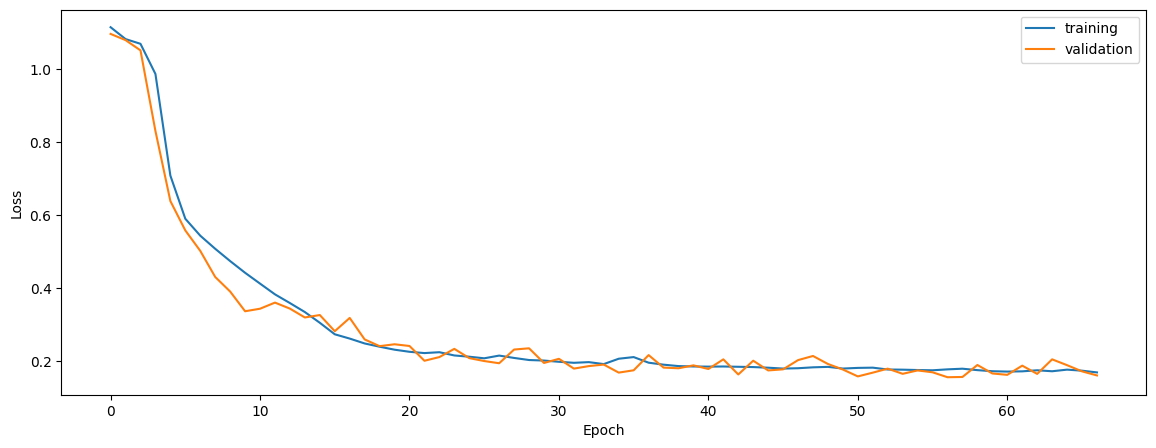

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.9336391287674911


0.9434566450326491


0.9076573780087624


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.9486596556957223


0.947728665803991


0.9057117162819656


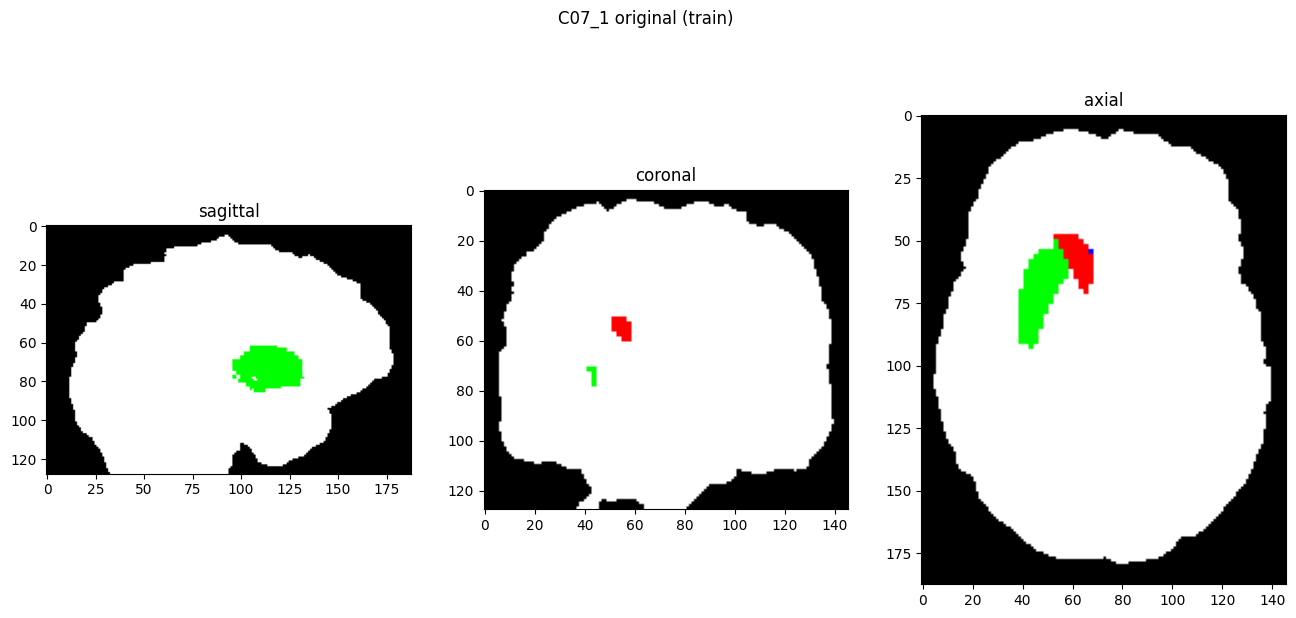

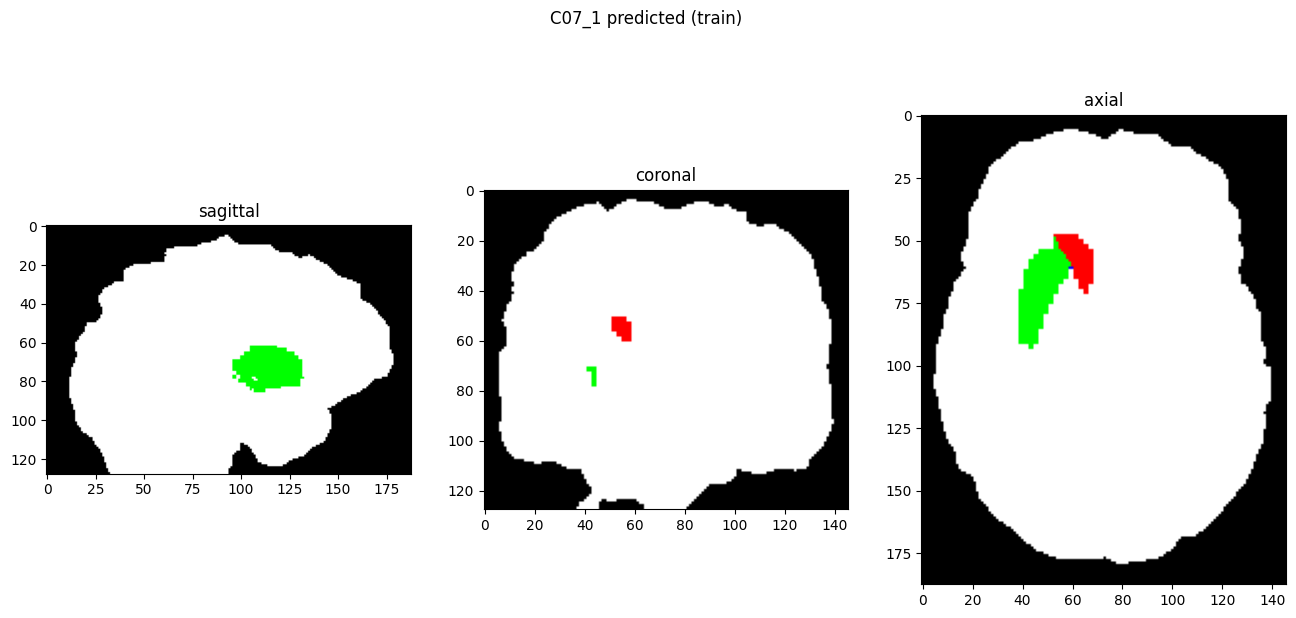

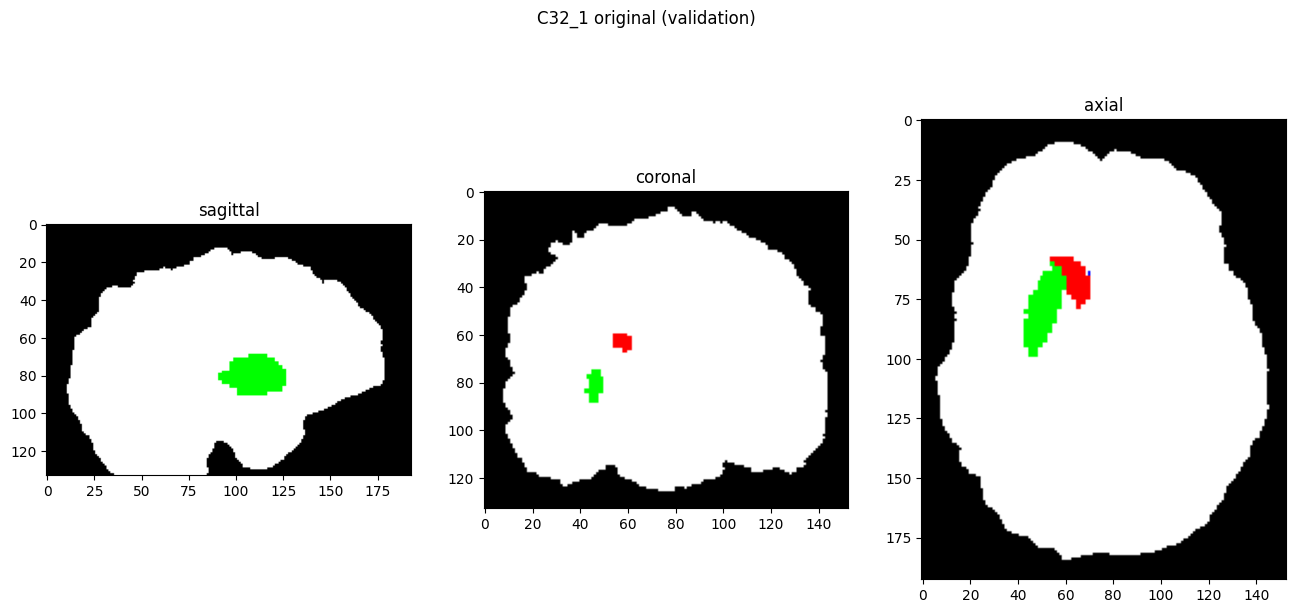

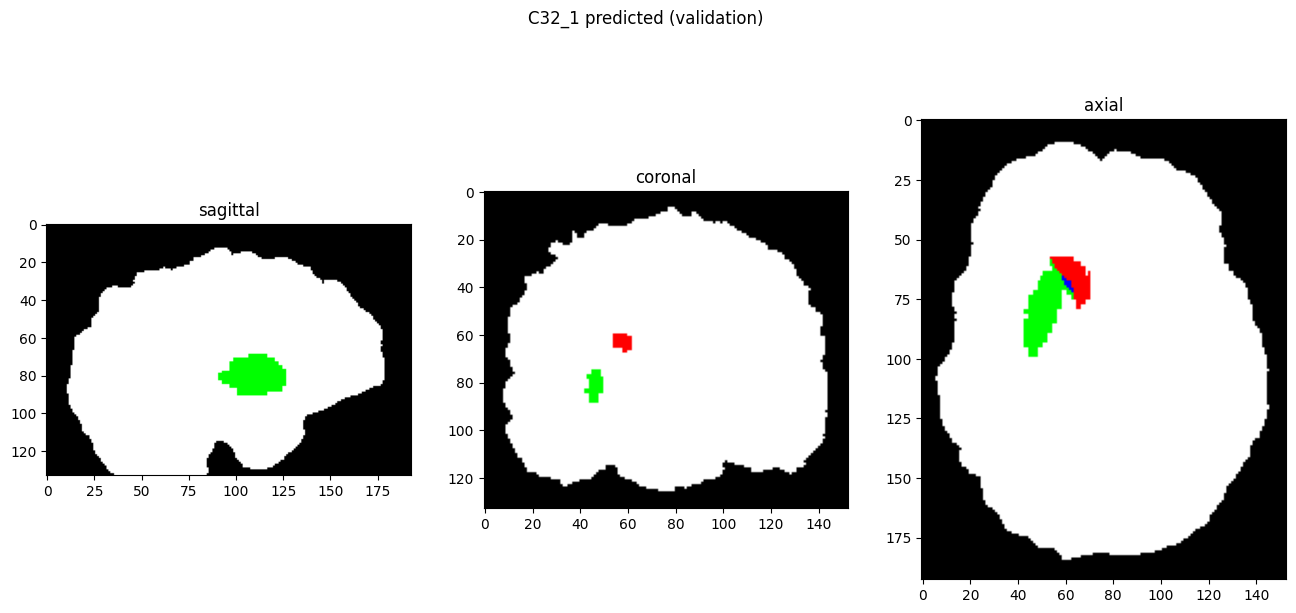

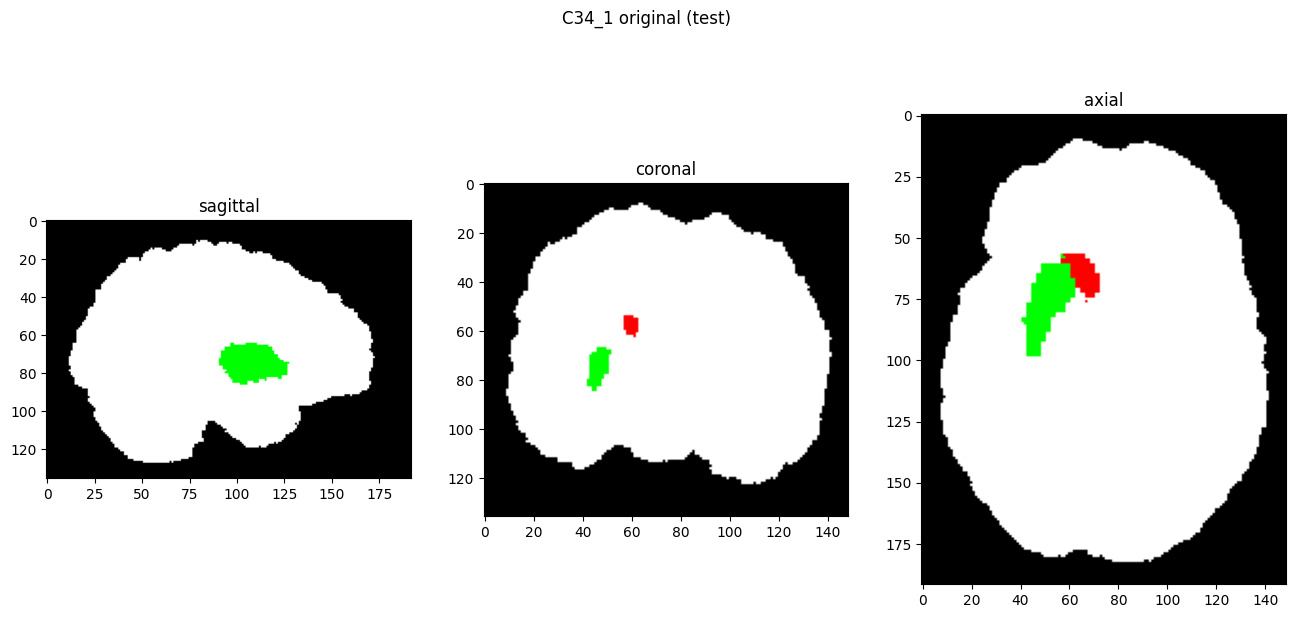

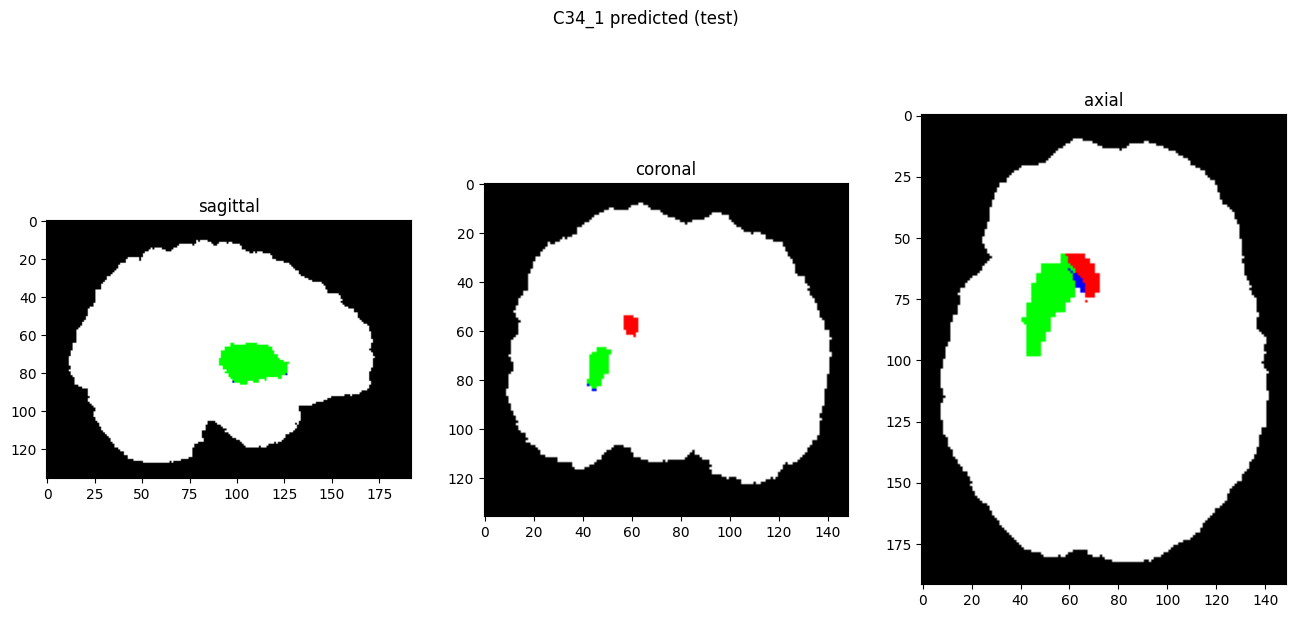

In [9]:
showResults(model, gen, threshold=0)